In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import json

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-paper')
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

## Pretty plotting learning curves from tensorflow

### Notes:
  * need to install a latex distribution to use latex in matplotlib plotting
      `sudo apt-get install texlive texstudio`

In [3]:
from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow import errors

def read_events(path, tags=('loss', 'ppl'), out=None,):
    """
    Read and parse tensorboard events file into a dictionary of arrays
    
    Parameters
    ==========
    path : str, path-like
        path to tensorboard event file
    tags : tuple (optional)
        tuple of string tags to extract from events file
    out : dict (optional)
        dictionary to modify in place for accumulating multiple event files
    
    Returns
    =======
    out: dict
        given tags will be keys containing arrays with indices [step, value]
    """
    out = out if out is not None else {t: [] for t in tags}
    sit = summary_iterator(path)
    step_start = 0
    try:
        e = next(sit)
        while e:
            for v in e.summary.value:
                if v.tag in tags:
                    if not step_start and out[v.tag] and  e.step < out[v.tag][-1][0]:
                        step_start = 2 * out[v.tag][-1][0] - out[v.tag][-2][0]
                        
                    out[v.tag].append([e.step + step_start, v.simple_value])
            e = next(sit)
    except (errors.DataLossError, StopIteration) as _:
        pass
    return out

def read_events_dir(path, tags=('loss', 'ppl', 'lr')):
    """
    Read and merge tensorboard events files from a single directory
    
    Parameters
    ==========
    path : str, path-like
        Path to directory containing tensorboard events files
    tags : tuple (optional)
        tuple of string tags to extract from events file
    
    Returns
    =======
    out : dict
        given tags will be keys containing arrays with indice [step, value]
        NOTE: the paths are sorted, so if the file names contains time-like
        quantities the steps will be in the correct order, but you should
        sort the arrays by steps to ensure this.
    """
    out = {t: [] for t in tags}
    for eventfile in sorted(Path(path).iterdir()):
        out = read_events(str(eventfile), tags, out)
    return out

In [3]:
curves = {
    'Pretrained training': read_events_dir('data/tb-dlts-logs/2020-03-29-pretrained/train/'),
    'Pretrained validation': read_events_dir('data/tb-dlts-logs/2020-03-29-pretrained/valid/'),
    'Training': read_events_dir('data/tb-dlts-logs/2020-02-25/train/'),
    'Validation': read_events_dir('data/tb-dlts-logs/2020-02-25/valid/')
}

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [65]:
# Reload pre-trained model other
curves['Pretrained training'] = read_events_dir('/home/colin/projects/docstring-method-modeling/tb-dlts-logs/2020-03-29-pretrained/train/')
curves['Pretrained validation'] = read_events_dir('/home/colin/projects/docstring-method-modeling/tb-dlts-logs/2020-03-29-pretrained/valid/')

[13, 34.560001373291016] ppl 13 14
[41229, 3.75] ppl 1 41229
[41215, 4.360000133514404] ppl 143 43386


Text(0.5, 0, 'Optimization steps')

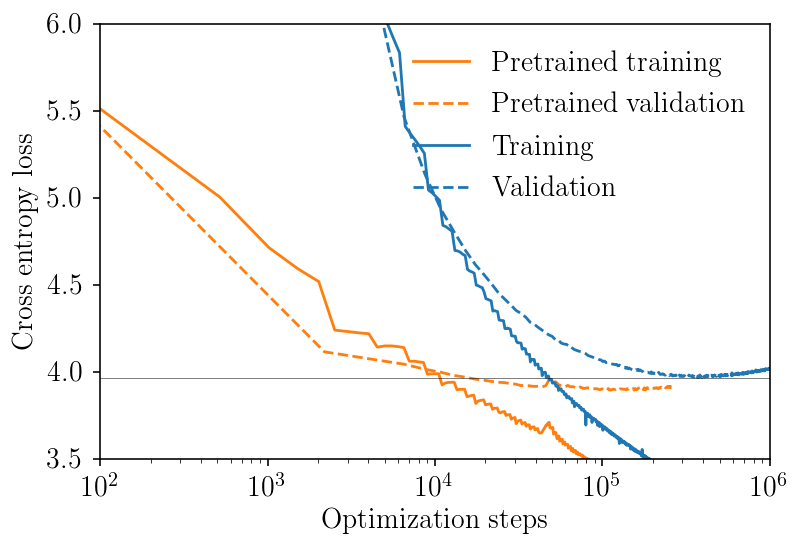

In [66]:
datadirs = {'Pretrained': Path('data/tb-dlts-logs/2020-03-29-pretrained/'),
            '': Path('data/tb-dlts-logs/2020-02-25')}

props = {
    'Training': {'c': '#1f77b4'},
    'Validation': {'c': '#1f77b4', 'linestyle': 'dashed'},
    'Pretrained training': {'c': '#ff7f0e'},
    'Pretrained validation': {'c': '#ff7f0e', 'linestyle': 'dashed'}
}

for label, data in curves.items():
    dat = np.array(data['loss'])
    #dat = dat[np.argsort(dat[:,0])]
    if 'training' in label.casefold():
        dat = dat[3::500]

    plt.plot(*dat.T, label=label, **props[label])
    if label is 'Validation':
        plt.axhline(dat[np.argmin(dat[:,1])][1], c='k', lw=0.25)

plt.legend(loc='upper right')
axe = plt.gca()
axe.set_xlim([100, 1_000_000])
axe.set_ylim([3.5, 6.0])
axe.set_xscale('log')
#axe.set_yscale('log')
axe.set_ylabel('Cross entropy loss')
axe.set_xlabel('Optimization steps')

In [222]:
loss = np.array(curves['Validation']['loss'])
best_step = loss[np.argmin(loss[:,1])][0]

pt_loss = np.array(curves['Pretrained validation']['loss'])
pt_best_step = pt_loss[np.argmin(np.abs(pt_loss[:,1] - loss[np.argmin(loss[:,1])][1]))][0]

print(f"Original model reached best valid loss at {best_step} steps")
print(f"Pretrained model reached same valid loss at {pt_best_step}")
print(f"Pretraining is {best_step/pt_best_step} times faster!")

Original model reached best valid loss at 397813.0 steps
Pretrained model reached same valid loss at 15191.0
Pretraining is 26.18741360015799 times faster!


## Multi-task training

In [418]:
logdir = Path('/home/coclemen/2020-04-17-tblogs/2020-04-17')
curve_dirs = list(logdir.iterdir())
curves = {cdir.name: read_events_dir(cdir) for cdir in curve_dirs}

In [426]:
name_map = {
        'train': 'Average Training',
        'valid': 'Sig $\\to$ Doc',
        'valid1': 'Sig $\\to$ Body',
        'valid2': 'Sig $\\to$ Doc + Body',
        'valid3': 'Doc $\\to$ Body',
        'valid4': 'Doc $\\to$ Sig + Body',
        'valid5': 'Body $\\to$ Doc',
        'valid6': 'Body $\\to$ Sig + Doc',
        'valid7': 'Sig + Doc $\\to$ Body',
        'valid8': 'Sig + Body $\\to$ Doc',    
}
["#cb6a49",
"#a46cb7",
"#7aa457"]
linestyle = 'solid'

props = {
        'train': {'c': 'k'},
        'valid': {'linestyle': 'dashed', 'c': "#cb6a49"},
        'valid1': {'linestyle': linestyle, 'c': "#cb6a49"},
        'valid2': {'linestyle': 'dashed', 'c': "#cb6a49"},
        'valid3': {'linestyle': linestyle, 'c': "#a46cb7"},
        'valid4': {'linestyle': linestyle, 'c': "#a46cb7"},
        'valid5': {'linestyle': 'dashed', 'c': "#7aa457"},
        'valid6': {'linestyle': 'dashed', 'c': "#7aa457"},
        'valid7': {'linestyle': linestyle},
        'valid8': {'linestyle': 'dashed'},
}

Text(0.5, 0, 'Optimization steps')

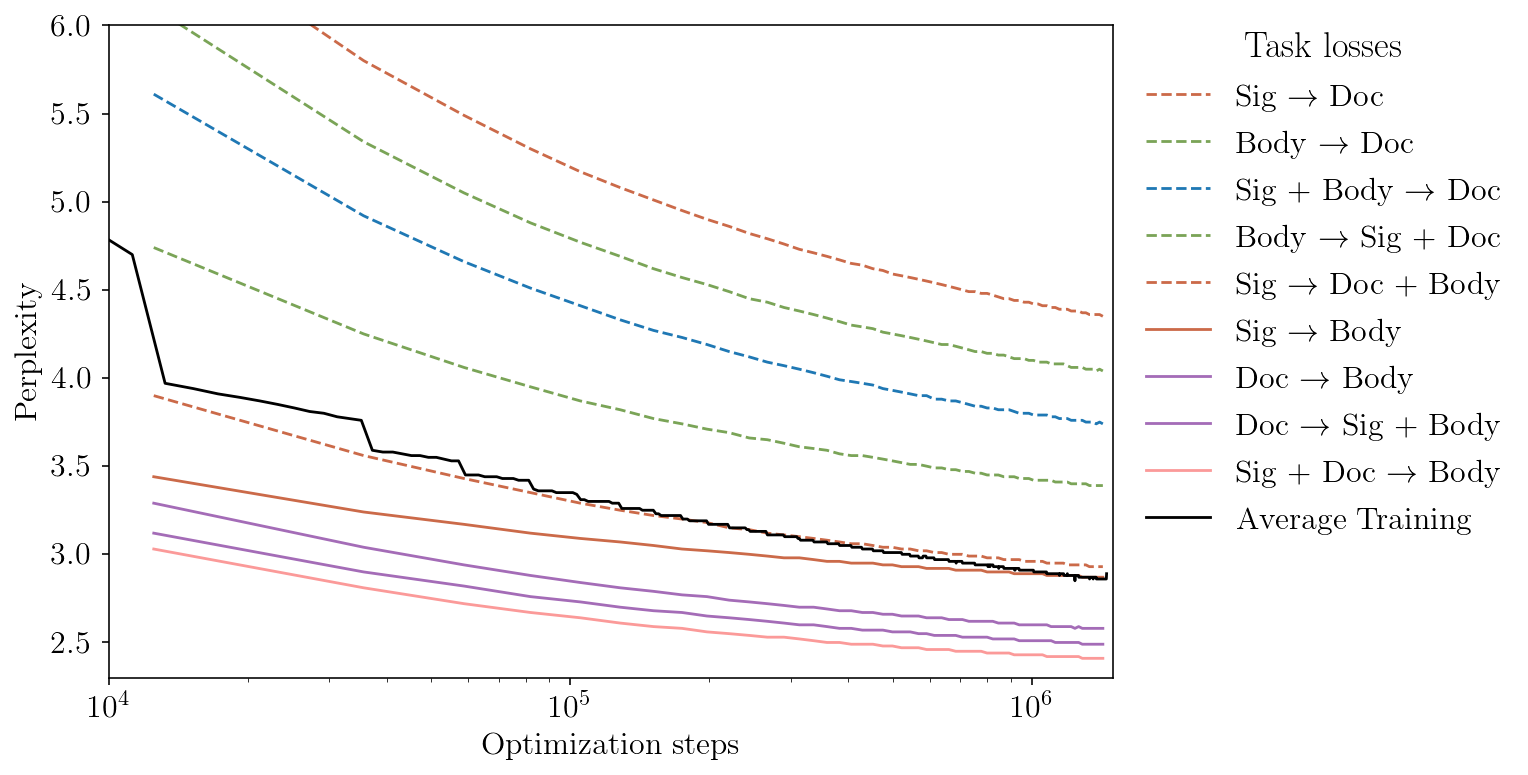

In [448]:
fig, axe = plt.subplots(figsize=(9, 6))
TAG = 'ppl'

#re_order = ['train', 'valid'] + [f'valid{i}' for i in range(1, 9)]
best_losses = dict([])
for label in curves:
    if not label == 'train':
        best_losses[label] = min([c[1] for c in curves[label][TAG]])
labels = list(best_losses.values())
re_order = ['train'] + sorted(best_losses, key=best_losses.get)
    
for label in re_order[::-1]:
    data = curves[label]
    dat = np.array(data[TAG])

    if 'train' in label.casefold():
        dat = dat[1241::2000]

    axe.plot(*dat.T, label=name_map[label], **props[label])  #, **props[label])
#     if label is 'Validation':
#         plt.axhline(dat[np.argmin(dat[:,1])][1], c='k', lw=0.25)

if TAG == 'loss':
    plt.ylim([3.05, 4.5])
    axe.set_ylabel('Cross entropy loss')
else:
    plt.ylim([2.3, 6.])
    axe.set_ylabel('Perplexity')
plt.xlim([10_000, 1_500_000])
axe.set_xscale('log')
#axe.set_yscale('log')
leg = plt.legend(loc=(1.02, 0.2))
leg.set_title('Task losses',prop={'size':18})


axe.set_xlabel('Optimization steps')

In [449]:
for label in re_order[1:]:
    name = name_map[label].replace('$\\to$', '->').ljust(18)
    print(f'{name}:\t {best_losses[label]:.3f}')

Sig + Doc -> Body :	 2.410
Doc -> Sig + Body :	 2.490
Doc -> Body       :	 2.580
Sig -> Body       :	 2.870
Sig -> Doc + Body :	 2.930
Body -> Sig + Doc :	 3.390
Sig + Body -> Doc :	 3.740
Body -> Doc       :	 4.040
Sig -> Doc        :	 4.350


[]

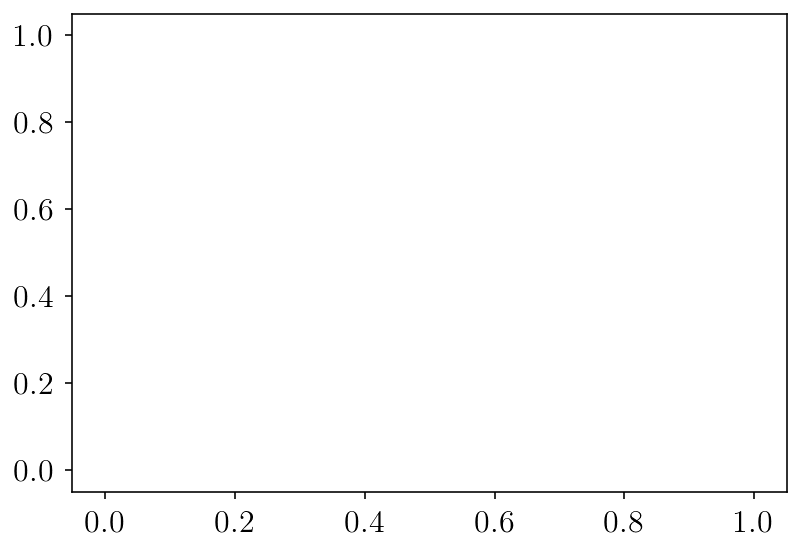

In [450]:
plt.plot(*np.array(curves['train']['lr']).T)

In [453]:
len(curves['valid']['loss'])

62

In [356]:
features = ['sig', 'doc', 'body', 'sig + doc', 'sig + body', 'doc + body']
best_loss_matrix = np.zeros((len(features), len(features)))
for label, name in name_map.items():
    if label == 'train':
        continue
    src, tgt = name.split('$\\to$')
    src_i = features.index(src.casefold().strip())
    tgt_i = features.index(tgt.casefold().strip())
    best_loss_matrix[tgt_i, src_i] = best_losses[label]

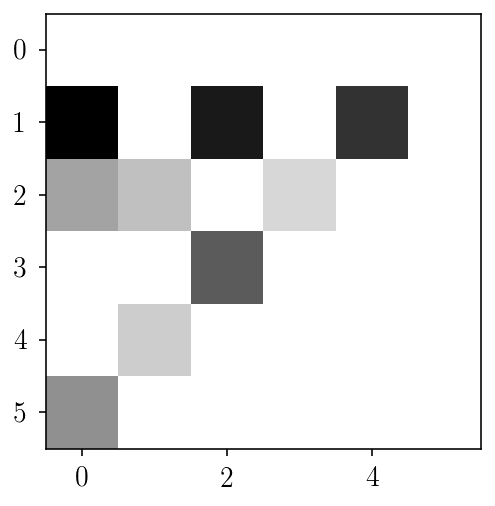

In [209]:
plt.imshow(best_loss_matrix, cmap='gray_r', vmin=0.95*min(best_losses.values()))

In [5]:
logdir = Path('/home/coclemen/tb-dlts-logs/2020-07-31-js-method')
curve_dirs = list(logdir.iterdir())
curves = {cdir.name: read_events_dir(cdir) for cdir in curve_dirs}

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


(3, 6)

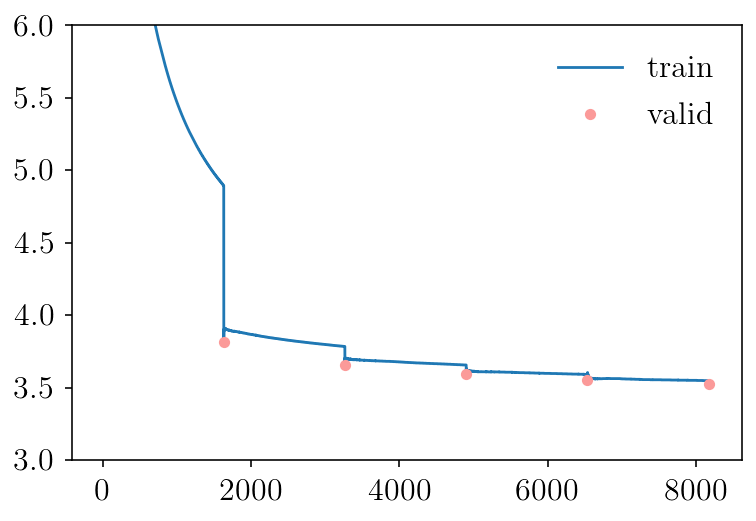

In [16]:
plt.plot(*np.array(curves['train']['loss']).T, label='train')
plt.plot(*np.array(curves['valid']['loss']).T, 'o', label='valid')
plt.legend()
plt.ylim([3, 6])